### 減掉連續譜
因為我的 cube 看起來（也確實是）沒減過連續譜的樣子  
這樣算比值絕對會出問題的吧啊！  
所以要先做這個  

技術：  
除了簡單的減連續譜之外，應該還要對於混合線做一些 fitting  
(但這個 cube 顆粒分明耶，私以為。)  

ref :  
Jet-mode feedback in NGC 5972: insights from resolved MUSE, GMRT and VLA observations  
https://iopscience.iop.org/article/10.3847/1538-4357/adc38d/pdf


處理的 cube :  
從 ESO 上抓下來的，觀測儀器是 MUSE(single)  
統一使用波長單位:4759-9320 ang（補藥換成頻率啊）      
pID = 094.B-0321

In [10]:
# modular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from time import perf_counter as clock # 記錄程式時間戳記
from pathlib import Path
from urllib import request

from ppxf.ppxf import ppxf
from ppxf.ppxf_util import log_rebin
#import ppxf.ppxf_util as util # 抓網路資料的
#import ppxf.sps_util as lib # 高級路徑工具

### Getting data an some information

#### initial setting
不知道是不是初始化  
但總之大全域的東西都設在這裡

In [11]:
c = 299792.458  # [km/s]
z = 0.001448 # circinus galaxy
file_path = "/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits" # FITS

#### data from the cube
這邊要取值了
把整條光譜除以其中位數，將整條光譜 scale 調整到大約在 ~1 的範圍內

In [ ]:
muse_hdul = fits.open(file_path)
muse_hdul.info() # DATA:cube, STAT:noise?
muse_data = muse_hdul['DATA'].data # (RA, DEC, AWAV)
muse_header = muse_hdul['DATA'].header


# normalization
print(muse_data[1000, 150, 200])
#galaxy = t['flux']/np.median(t['flux'])

Filename: /Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1341   ()      
  1  DATA          1 ImageHDU        43   (317, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (317, 319, 3682)   float32   
401.19235


### Wave Length Array

#### original wave length array
假設 MUSE 的波長是**線性**波長軸  
就是從開始到結束均勻的切成 3682 份，線性   
反正就是依照 header 的資訊**做**出一個代表波長軸的陣列   
才有後續的計算。

建立軸陣列的概念：   
for i in range(naxis3):
    ori_lam[i] = CRVAL3 + (i + 1 - CRPIX3) * CDELT3   
總之就是 array

Header kw 的一些解釋:  

- CRVAL3: 起始波長
- CD3_3 : 頻率解析度，波長版。但kw和阿瑪(CDELT3)不一樣
- CRPIX3: 第 crpix3 個 pix 的波長 = crval3
- NAXIS3: 第三軸長度，整條軸切成幾塊(channel)的意思  


In [ ]:
# ori WAV axis
crval3 = muse_header['CRVAL3']
cdelt3 = muse_header['CD3_3']
crpix3 = muse_header['CRPIX3']
naxis3 = muse_header['NAXIS3']
ori_lamb = crval3 + (np.arange(naxis3) + 1 - crpix3) * cdelt3

In [ ]:
# check the shape
print(f"Original WAV axis's shape = {ori_lamb.shape}") # 3682, same as the last dimension of DATA
print(f"Three dimentions of original data cube = {muse_data.shape}") # 下面那個陣要擺得和這個一樣
'''
n 久之前也遇過一樣的！
info 顯示的和實際 shape 的軸的順序不一樣
'''
i, j = muse_data.shape[1]//2, muse_data.shape[2]//2
spectrum = muse_data[:, i, j] # 光譜，縱軸或是 flux 的部分，一樣的意思
print(f"？？？ = {spectrum.shape}")#欸等一下我不知道這具體來說是什麼喔喔喔等我咪玩再看

if spectrum.shape==ori_lamb.shape : # 他媽的這本來就要一樣吧
    print('Nice ^_-!')

Original WAV axis's shape = (3682,)
Three dimentions of original data cube = (3682, 319, 317)
WAV axis's shape after rebinning = (3682,)
Nice ^_-!


#### Log wave length array
pPXF 要求 spectrum 要是「等速率」取樣的，  
而這正好對應到波長軸需為等距的 log(λ) 軸

底層原因：  

pPXF 是透過在「速度空間」中擬合星體或氣體的光譜位移，  
都卜勒效應：  
$v = c \cdot \frac{\Delta \lambda}{\lambda} \Rightarrow \log(\lambda)$

如果你在「等速率」間距的 grid（也就是 log(λ) 軸）上取樣，  
就可以把光譜紅移 / 藍移轉成 簡單的線性 shift，  
讓 pPXF 更容易做出 convolution 和 fitting。

**好其實這邊我沒有讀太懂**

Velocity resolu(?) on ln-WAV axis (km/s) = 55.17


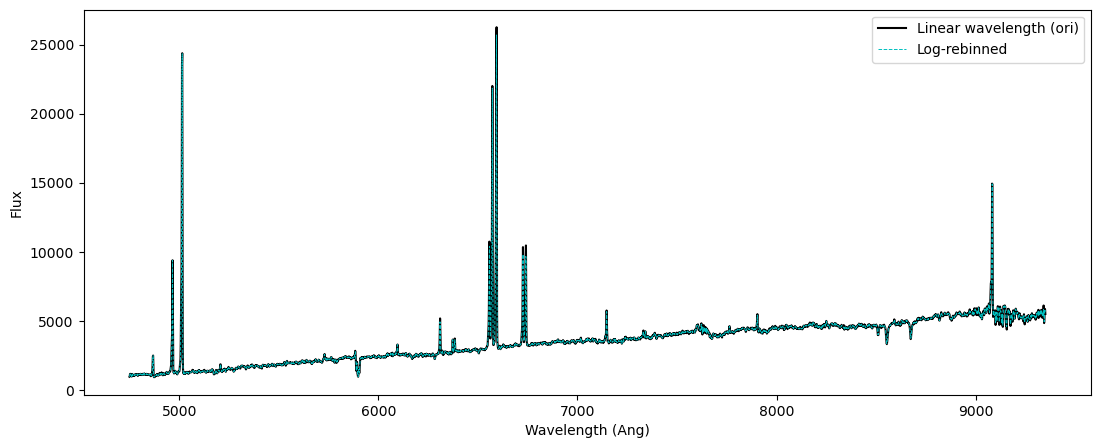

"\nt = hdu['COADD'].data #蠔\nredshift_0 = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate\n\ngalaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues\nln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln #這個我應該不用做ㄌ？\nlam_gal = np.exp(ln_lam_gal)                # Wavelength in Angstroms (log sampled)\nlam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal) # 真空/空氣波長的修正，muse是空氣我記得\nnoise = np.full_like(galaxy, 0.0149)  # Assume constant noise per pixel here啊我的noise 要自己估嗎\n#MUSE cube 中的 noise cube，通常在 FITS 的 STAT 或 ERR extension\n"

In [9]:
# Log WAV axis
ln_spectrum, ln_lam, velscale = log_rebin([ori_lam[0], ori_lam[-1]], spectrum) # 重採樣後的光譜, 對應的自然對數波長軸, 波長解析度轉速度（？）
print(f"Velocity resolu(?) on ln-WAV axis (km/s) = {velscale:.2f}")


# 畫出來看看
# og-rebin 會讓高波長區 sampling 點變多、低波長變少。(by C)
plt.figure(figsize=(13, 5))
plt.plot(ori_lam, spectrum, c='k', label='Linear wavelength (ori)')
plt.plot(np.exp(ln_lam), ln_spectrum, c='c', lw=0.7, label='Log-rebinned', linestyle='--')
plt.xlabel("Wavelength (Ang)")
plt.ylabel("Flux")
plt.legend()
plt.show()




# 老哥的 github 裡寫的東西，不知道在幹啥
'''
t = hdu['COADD'].data #蠔
redshift_0 = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate

galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln #這個我應該不用做ㄌ？
lam_gal = np.exp(ln_lam_gal)                # Wavelength in Angstroms (log sampled)
lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal) # 真空/空氣波長的修正，muse是空氣我記得
noise = np.full_like(galaxy, 0.0149)  # Assume constant noise per pixel here啊我的noise 要自己估嗎
#MUSE cube 中的 noise cube，通常在 FITS 的 STAT 或 ERR extension
'''

In [ ]:
temp_path = '/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/spectra_emiles_9.0.npz'


In [ ]:

t = hdu['COADD'].data 
redshift_0 = hdu['SPECOBJ'].data['z'].item()       # SDSS redshift estimate

galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
lam_gal = np.exp(ln_lam_gal)                # Wavelength in Angstroms (log sampled)
lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal) # 真空/空氣波長的修正
noise = np.full_like(galaxy, 0.0149)  # Assume constant noise per pixel here

The velocity step was already chosen by the SDSS pipeline and I convert it below to km/s. 
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)

I convert the instrumental dispersion to Angstroms
dlam_gal = np.gradient(lam_gal)             # Size of every pixel in Angstroms
wdisp = t['wdisp']                          # Instrumental dispersion of every pixel, in pixels units
fwhm_gal = 2.355*wdisp*dlam_gal             # Resolution FWHM of every pixel, in Angstroms

In general, especially at significant redshift, it is easier to bring the galaxy spectrum roughly to the rest-frame wavelength, before calling pPXF (See Sec.2.4 of Cappellari 2017).
In practice there is no need to modify the spectrum in any way, given that a red shift corresponds to a linear shift of the log-rebinned spectrum. 
One just needs to compute the wavelength range in the rest-frame and adjust the instrumental resolution of the galaxy observations.
lam_gal = lam_gal/(1 + redshift_0)      # Compute approximate restframe wavelength
fwhm_gal = fwhm_gal/(1 + redshift_0)    # Adjust resolution in Angstroms